# Time Series Mixer (TSMixer)
This notebook walks through how to use Darts' `TSMixerModel` and benchmarks it against `TiDEModel`.

TSMixer (Time-series Mixer) is an all-MLP architecture for time series forecasting. 

It does so by integrating historical time series data, future known inputs, and static contextual information. The architecture uses a combination of conditional feature mixing and mixer layers to process and combine these different types of data for effective forecasting.

Translated to Darts, this model supports all types of covariates (past, future, and/or static).

See the original paper and model description [here](https://arxiv.org/abs/2303.06053).

According to the authors, the model outperforms several state-of-the-art models on multivariate forecasting tasks.

Let's see how it performs against `TideModel` on the ETTh1 and ETTh2 datasets.

In [1]:
# fix python path if working locally
import sys
from os import getcwd
from os.path import basename, dirname


def fix_pythonpath_if_working_locally():
    """Add the parent path to pythonpath if current working dir is darts/examples"""
    cwd = getcwd()
    if basename(cwd) == "examples":
        sys.path.insert(0, dirname(cwd))
fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# 匯入您想使用的 Profiler 類別
from pytorch_lightning.profilers import SimpleProfiler, AdvancedProfiler
from darts import concatenate
from darts.dataprocessing.transformers.scaler import Scaler
from darts.datasets import ETTh1Dataset, ETTh2Dataset
from darts.metrics import mql
from darts.models import TiDEModel, TSMixerModel
from darts.utils.callbacks import TFMProgressBar
from darts.utils.likelihood_models.torch import QuantileRegression


# Data Loading and preparation
We consider the ETTh1 and ETTh2 datasets which contain hourly multivariate data of an electricity transformer (load, oil temperature, ...).
You can find more information [here](https://unit8co.github.io/darts/generated_api/darts.datasets.html#darts.datasets.ETTh1Dataset).

We will add static information to each transformer time series, that identifies whether it is the `ETTh1` or `ETTh2` transformer.
Both TSMixer and TiDE can levarage this information.
Electricity transformer temperature (hourly, 2016-2018)



In [4]:
series = []
for idx, ds in enumerate([ETTh1Dataset, ETTh2Dataset]):
    trafo = ds().load().astype(np.float32)
    trafo = trafo.with_static_covariates(pd.DataFrame({"transformer_id": [idx]}))
    series.append(trafo)
series[0].to_dataframe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...
2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000


In [5]:
series[1].to_dataframe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
2016-07-01 02:00:00,37.946999,11.309,35.330002,9.007,2.100,0.000,36.465000
2016-07-01 03:00:00,38.952000,11.895,35.543999,9.436,3.380,1.215,33.608501
2016-07-01 04:00:00,38.113998,11.476,35.410000,9.623,2.036,0.000,31.850500
...,...,...,...,...,...,...,...
2018-06-26 15:00:00,39.202999,11.392,49.644001,11.929,-10.331,-1.258,47.084999
2018-06-26 16:00:00,38.113998,10.974,48.759998,11.366,-10.331,-1.290,48.183498
2018-06-26 17:00:00,39.622002,10.974,50.609001,11.661,-11.557,-1.418,48.183498


Before training, we split the data into train, validation, and test sets. The model will learn from the train set, use the validation set to determine when to stop training, and finally be evaluated on the test set.

In [6]:
train, val, test = [], [], []
for trafo in series:
    train_, temp = trafo.split_after(0.6)
    val_, test_ = temp.split_after(0.5)
    train.append(train_)
    val.append(val_)
    test.append(test_)

Lets look at the splits for the first column "HUFL" for each transformer

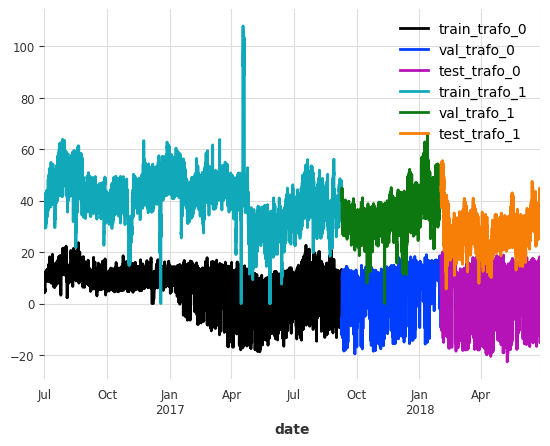

In [7]:
show_col = "HUFL"
for idx, (train_, val_, test_) in enumerate(zip(train, val, test)):
    train_[show_col].plot(label=f"train_trafo_{idx}")
    val_[show_col].plot(label=f"val_trafo_{idx}")
    test_[show_col].plot(label=f"test_trafo_{idx}")

Now let's scale the data. To avoid leaking information from the validation and test sets, we scale the data based on the properties of the train set.

In [8]:
scaler = Scaler()  # default uses sklearn's MinMaxScaler
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

# Model Parameter Setup
Boilerplate code is no fun, especially in the context of training multiple models to compare performance. To avoid this, we use a common configuration that can be used with any Darts `TorchForecastingModel`.

A few interesting things about these parameters:

- **Gradient clipping:** Mitigates exploding gradients during backpropagation by setting an upper limit on the gradient for a batch.
- **Learning rate:** The majority of the learning done by a model is in the earlier epochs. As training goes on it is often helpful to reduce the learning rate to fine-tune the model. That being said, it can also lead to significant overfitting.
- **Early stopping:** To avoid overfitting, we can use early stopping. It monitors a metric on the validation set and stops training once the metric is not improving anymore based on a custom condition.
- **Likelihood and Loss Functions:** You can either make the model probabilistic with a `likelihood`, or deterministic with a `loss_fn`. In this notebook we train probabilistic models using QuantileRegression.
- **Reversible Instance Normalization:** Use [Reversible Instance Normalization](https://openreview.net/forum?id=cGDAkQo1C0p) which in most of the cases improves model performance.
- **Encoders:** We can encode time axis/calendar information and use them as past or future covariates using `add_encoders`. Here, we'll add cyclic encodings of the hour, day of the week, and month as future covariates

In [9]:
def create_params(
    input_chunk_length: int,
    output_chunk_length: int,
    full_training=True,
    enable_profiling=True,
):
    # early stopping: this setting stops training once the the validation
    # loss has not decreased by more than 1e-5 for 10 epochs
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=10,
        min_delta=1e-5,
        mode="min",
    )

    # PyTorch Lightning Trainer arguments (you can add any custom callback)
    if full_training:
        limit_train_batches = None
        limit_val_batches = None
        max_epochs = 200 # 200
        batch_size = 256
    else:
        limit_train_batches = 20
        limit_val_batches = 10
        max_epochs = 40
        batch_size = 64

    # only show the training and prediction progress bars
    progress_bar = TFMProgressBar(
        enable_sanity_check_bar=False, enable_validation_bar=False
    )
    profiler = None
    if enable_profiling:
        # 選擇 Profiler：SimpleProfiler 輸出到終端機；AdvancedProfiler 輸出檔案
        # 建議從 SimpleProfiler 開始，之後可以嘗試advanced profiler
        profiler = SimpleProfiler(dirpath="./profiler_results", filename="Advanced_Profiler")
        
        # 如果想使用 PyTorch 內建的 Profiler (更詳細但開銷較大):
        # from pytorch_lightning.profilers import PyTorchProfiler
        # profiler = PyTorchProfiler(dirpath="./profiler_results", filename="pytorch_profiler")
    pl_trainer_kwargs = {
        "devices": [0],           # 🔥 關鍵：只用一個 GPU
        "gradient_clip_val": 1,
        "max_epochs": max_epochs,
        "limit_train_batches": limit_train_batches,
        "limit_val_batches": limit_val_batches,
        "accelerator": "auto",
        "callbacks": [early_stopper, progress_bar],
        "profiler": profiler,
    }

    # optimizer setup, uses Adam by default
    # optimizer_cls = torch.optim.Adam
    optimizer_kwargs = {
        "lr": 1e-4,
    }

    # learning rate scheduler
    lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
    lr_scheduler_kwargs = {"gamma": 0.999}

    # for probabilistic models, we use quantile regression, and set `loss_fn` to `None`
    likelihood = QuantileRegression()
    loss_fn = None

    return {
        "input_chunk_length": input_chunk_length,  # lookback window
        "output_chunk_length": output_chunk_length,  # forecast/lookahead window
        "use_reversible_instance_norm": True,
        "optimizer_kwargs": optimizer_kwargs,
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": lr_scheduler_kwargs,
        "likelihood": likelihood,  # use a `likelihood` for probabilistic forecasts
        "loss_fn": loss_fn,  # use a `loss_fn` for determinsitic model
        "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
        "force_reset": True,
        "batch_size": batch_size,
        "random_state": 42,
        "add_encoders": {
            "cyclic": {
                "future": ["hour", "dayofweek", "month"]
            }  # add cyclic time axis encodings as future covariates
        },
    }

# Model configuration
Let's use the last week of hourly data as lookback window (`input_chunk_length`) and train a probabilistic model to predict the next 24 hours directly (`output_chunk_length`). Additionally, we tell the model to use the static information. To keep the notebook simple, we'll set `full_training=False`. To get even better performance, set `full_training=True`.

Apart from that, we use our helper function to set up all the common model arguments.

In [10]:

input_chunk_length = 7 * 24
output_chunk_length = 24
use_static_covariates = True
full_training = True
enable_profiling = False 

In [11]:
# create the models
model_tsm = TSMixerModel(
    **create_params(
        input_chunk_length,
        output_chunk_length,
        full_training=full_training,
        enable_profiling=enable_profiling, # 🌟 傳入新參數
    ),
    use_static_covariates=use_static_covariates,
    model_name="tsm",
)
model_tide = TiDEModel(
    **create_params(
        input_chunk_length,
        output_chunk_length,
        full_training=full_training,
        enable_profiling=enable_profiling, # 🌟 傳入新參數
    ),
    use_static_covariates=use_static_covariates,
    model_name="tide",
)
models = {
    "TSM": model_tsm,
    # "TiDE": model_tide,
}

In [12]:
!export CUDA_VISIBLE_DEVICES=0

In [13]:
# 測量目前使用的gpu
import sys
import os
import platform
import torch

def check_environment_and_gpu():
    """
    檢查並輸出當前 Python 環境、虛擬環境狀態以及 PyTorch 的 GPU 資訊。
    """
    print("=" * 40)
    print("🛠️ 環境和解釋器檢查 (Environment & Interpreter Check)")
    print("=" * 40)
    
    # 1. 檢查 Python 版本和路徑
    print(f"Python 版本: {sys.version.split()[0]}")
    print(f"Python 路徑: {sys.executable}")
    
    # 2. 檢查是否在虛擬環境中 (venv 或 conda)
    if hasattr(sys, 'prefix') and sys.prefix != sys.base_prefix:
        print(f"虛擬環境: 🟢 正在使用 ({sys.prefix})")
    else:
        print("虛擬環境: 🔴 正在使用系統或基礎環境")
        
    print(f"作業系統/核心: {platform.system()} {platform.release()}")
    
    print("\n" + "=" * 40)
    print("💻 PyTorch 和 GPU 檢查 (PyTorch & GPU Check)")
    print("=" * 40)
    
    # 3. 檢查 PyTorch 版本
    print(f"PyTorch 版本: {torch.__version__}")
    
    # 4. 檢查 CUDA 是否可用
    if torch.cuda.is_available():
        print(f"CUDA 是否可用: 🟢 是")
        print(f"CUDA 版本: {torch.version.cuda}")
        
        # 5. 檢查可用的 GPU 數量及詳細資訊
        device_count = torch.cuda.device_count()
        print(f"可用的 GPU 數量: {device_count}")
        
        for i in range(device_count):
            gpu_name = torch.cuda.get_device_name(i)
            # 獲取總記憶體 (以 GB 為單位)
            total_memory = torch.cuda.get_device_properties(i).total_memory / (1024**3)
            print(f"   -> GPU {i} 名稱: {gpu_name} (總記憶體: {total_memory:.2f} GB)")
            
            # 6. 檢查當前 PyTorch 默認使用的設備
            current_device = torch.cuda.current_device()
            if i == current_device:
                 print("   -> 📌 這是當前 PyTorch 的默認設備")
            
    else:
        print("CUDA 是否可用: 🔴 否 (PyTorch 將使用 CPU 運行)")
        print("可用的 GPU 數量: 0")

# 執行檢查函式
check_environment_and_gpu()

🛠️ 環境和解釋器檢查 (Environment & Interpreter Check)
Python 版本: 3.13.5
Python 路徑: /storage/ssd3/datafox/miniconda3/bin/python
虛擬環境: 🔴 正在使用系統或基礎環境
作業系統/核心: Linux 6.5.0-35-generic

💻 PyTorch 和 GPU 檢查 (PyTorch & GPU Check)
PyTorch 版本: 2.9.0+cu128
CUDA 是否可用: 🟢 是
CUDA 版本: 12.8
可用的 GPU 數量: 9
   -> GPU 0 名稱: NVIDIA RTX 6000 Ada Generation (總記憶體: 47.50 GB)
   -> 📌 這是當前 PyTorch 的默認設備
   -> GPU 1 名稱: NVIDIA RTX A6000 (總記憶體: 47.53 GB)
   -> GPU 2 名稱: NVIDIA RTX A6000 (總記憶體: 47.53 GB)
   -> GPU 3 名稱: NVIDIA RTX A6000 (總記憶體: 47.53 GB)
   -> GPU 4 名稱: NVIDIA GeForce RTX 3090 (總記憶體: 23.68 GB)
   -> GPU 5 名稱: NVIDIA GeForce RTX 3090 (總記憶體: 23.68 GB)
   -> GPU 6 名稱: NVIDIA GeForce RTX 3090 (總記憶體: 23.68 GB)
   -> GPU 7 名稱: NVIDIA GeForce RTX 3090 (總記憶體: 23.68 GB)
   -> GPU 8 名稱: NVIDIA GeForce RTX 3090 (總記憶體: 23.68 GB)


# Model Training

In [14]:
# import cProfile

# p1 = cProfile.Profile()
# # p1.enable()

# # p2 = cProfile.Profile()
# # p1 is silently disabled here
# p1.disable()
# # p2.enable()
# # p2.disable()



### 最後版本結果 

In [15]:
# train the models and load the model from its best state/checkpoint

import time
for model_name, model in models.items():
    print(f"正在訓練{model_name}")
    start_t = time.time()
    model.fit(
        series=train,
        val_series=val,
    )
    # load from checkpoint returns a new model object, we store it in the models dict
    models[model_name] = model.load_from_checkpoint(
        model_name=model.model_name, best=True
    )
    end_t = time.time()
    print(f"{model_name} 訓練總花費時間：{end_t-start_t}秒")
    # 時間越來越快？我問號 92.03689241409302秒 vs  32.05158185958862秒

正在訓練TSM


Training: 0it [00:00, ?it/s]

TSM 訓練總花費時間：163.90640425682068秒


Now let's train all of the models. When using early stopping it is important to save checkpoints. This allows us to continue past the best model configuration and then restore the optimal weights once training has been completed.

### 資料紀錄：full, early-stopping
- TSM: epoch 47  81/81 [00:02<00:00, 37.88it/s, train_loss=0.186, val_loss=0.226] 98.21297955513秒
- TIDE: epoch 20  81/81 [00:01<00:00, 43.86it/s, train_loss=0.173, val_loss=0.256] 35.72478270530701秒
- 差異在early stopping

然後如果是加上profiler但是這個時間應該是失真的

- 正在訓練TSM
- TSM 訓練總花費時間：147.0999629497528秒
- 正在訓練TiDE
- TiDE 訓練總花費時間：56.03784704208374秒

# Backtest the probabilistic models

Let's configure the prediction. For this example, we will:

- generate **historical forecasts** on the test set using the **pre-trained models**. Each forecast covers a 24 hour horizon, and the time between two consecutive forecasts is also 24 hours. This will give us **276 multivariate forecasts per transformer** to evaluate the model!
- generate **500 stochastic samples** for each prediction point (since we have trained probabilistic models)
- evaluate/**backtest** the probabilistic historical forecasts for some quantiles **using the Mean Quantile Loss** (`mql()`).

And we'll create some helper functions to generate the forecasts, compute the backtest, and to visualize the predictions.

In [16]:
# configure the probabilistic prediction
num_samples = 500
forecast_horizon = output_chunk_length

# compute the Mean Quantile Loss over these quantiles
evaluate_quantiles = [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95]


def historical_forecasts(model):
    """Generates probabilistic historical forecasts for each transformer
    and returns the inverse transformed results.

    Each forecast covers 24h (forecast_horizon). The time between two forecasts
    (stride) is also 24 hours.
    """
    hfc = model.historical_forecasts(
        series=test,
        forecast_horizon=forecast_horizon,
        stride=forecast_horizon,
        last_points_only=False,
        retrain=False,
        num_samples=num_samples,
        verbose=True,
    )
    return scaler.inverse_transform(hfc)


def backtest(model, hfc, name):
    """Evaluates probabilistic historical forecasts using the Mean Quantile
    Loss (MQL) over a set of quantiles."""
    # add metric specific kwargs
    metric_kwargs = [{"q": q} for q in evaluate_quantiles]
    metrics = [mql for _ in range(len(evaluate_quantiles))]
    bt = model.backtest(
        series=series,
        historical_forecasts=hfc,
        last_points_only=False,
        metric=metrics,
        metric_kwargs=metric_kwargs,
        verbose=True,
    )
    bt = pd.DataFrame(
        bt,
        columns=[f"q_{q}" for q in evaluate_quantiles],
        index=[f"{trafo}_{name}" for trafo in ["ETTh1", "ETTh2"]],
    )
    return bt


def generate_plots(n_days, hfcs):
    """Plot the probabilistic forecasts for each model, transformer and transformer
    feature against the ground truth."""
    # concatenate historical forecasts into contiguous time series
    # (works because forecast_horizon=stride)
    hfcs_plot = {}
    for model_name, hfc_model in hfcs.items():
        hfcs_plot[model_name] = [
            concatenate(hfc_series[-n_days:], axis=0) for hfc_series in hfc_model
        ]

    # remember start and end points for plotting the target series
    hfc_ = hfcs_plot[model_name][0]
    start, end = hfc_.start_time(), hfc_.end_time()

    # for each target column...
    for col in series[0].columns:
        fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
        # ... and for each transformer...
        for trafo_idx, trafo in enumerate(series):
            trafo[col][start:end].plot(label="ground truth", ax=axes[trafo_idx])
            # ... plot the historical forecasts for each model
            for model_name, hfc in hfcs_plot.items():
                hfc[trafo_idx][col].plot(
                    label=model_name + "_q0.05-q0.95", ax=axes[trafo_idx]
                )
            axes[trafo_idx].set_title(f"ETTh{trafo_idx + 1}: {col}")
        plt.show()

Okay, now we're ready to evaluate the models

In [17]:
bts = {}
hfcs = {}
for model_name, model in models.items():
    print(f"Model: {model_name}")
    print("Generating historical forecasts..")
    hfcs[model_name] = historical_forecasts(models[model_name])

    print("Evaluating historical forecasts..")
    bts[model_name] = backtest(models[model_name], hfcs[model_name], model_name)

Model: TSM
Generating historical forecasts..


Predicting: 0it [00:00, ?it/s]

Generating TimeSeries:   0%|          | 0/276 [00:00<?, ?it/s]

Evaluating historical forecasts..


Let's see how they performed.

> **Note:** These results are likely to improve/change when setting `full_training=True`

In [18]:
bt_df = pd.concat(bts.values(), axis=0).sort_index()
bt_df

,q_0.05,q_0.1,q_0.2,q_0.5,q_0.8,q_0.9,q_0.95
ETTh1_TSM,0.451017,0.714141,1.090547,1.534331,1.042669,0.652053,0.394760
ETTh2_TSM,0.612591,0.956513,1.387394,1.782241,1.238919,0.792513,0.488605


The backtest gives us the Mean Quantile Loss for the selected quantiles over all transformer features per transformer and model. The lower the value, the better. The `q_0.5` is identical to the Mean Absolute Error (MAE) between the median prediction and the ground truth.

Both models seem to have performed comparably well. And how does it look on average over all quantiles?

In [19]:
bt_df.mean(axis=1)

ETTh1_TSM    0.839931
ETTh2_TSM    1.036968
dtype: float64

Here the results are also very similar. It seems that TSMixer performed better for ETTh1, and TiDEModel for ETTh2.

And last but not least, let's have look at the predictions for the last `n_days=3` days in the test set.

> Note: The prediction intervals are expected to get narrower when `full_training=True`

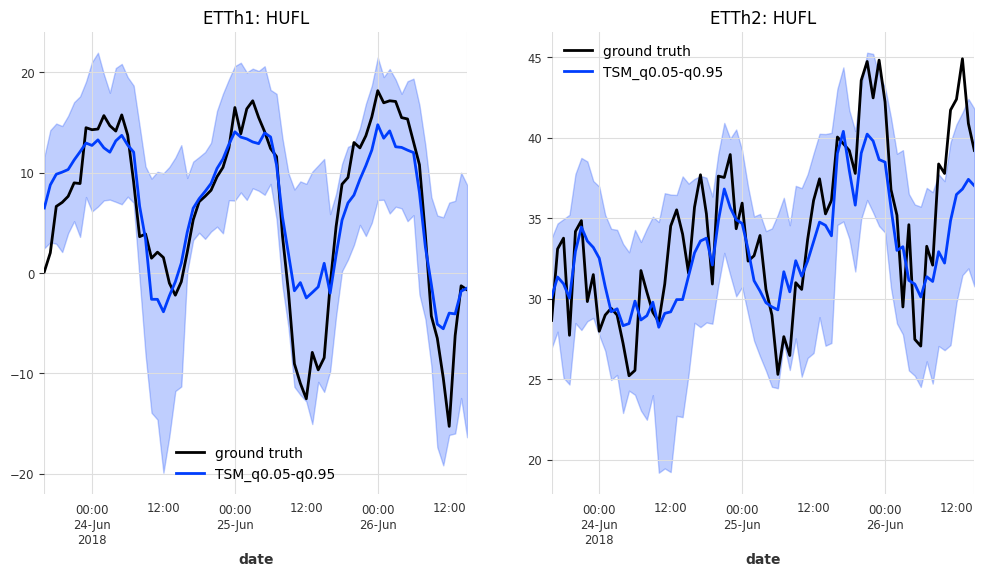

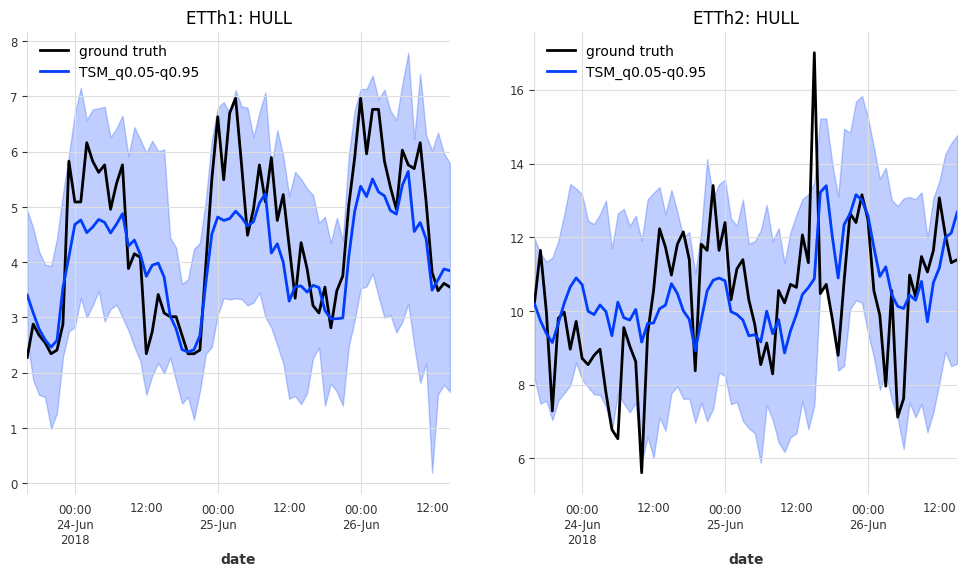

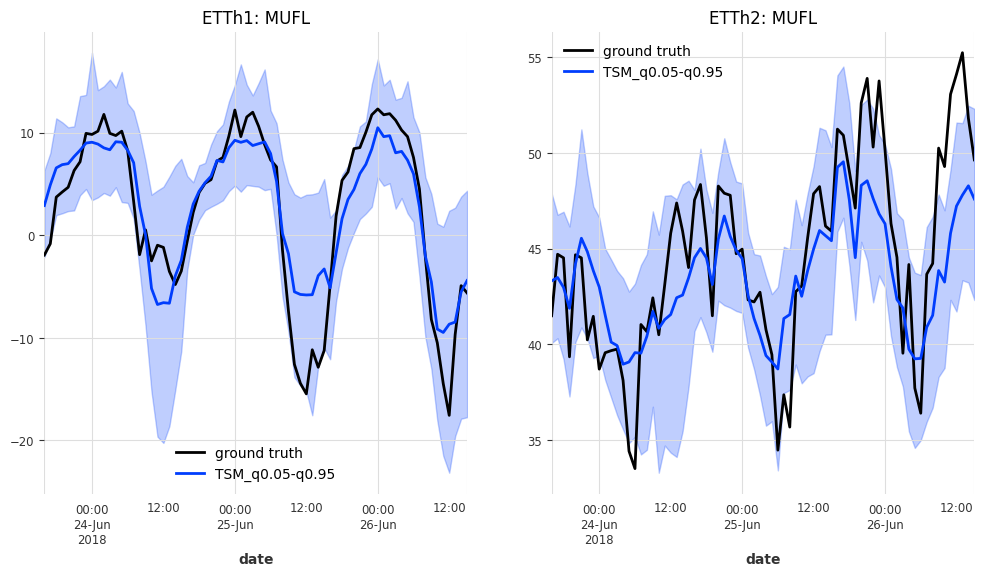

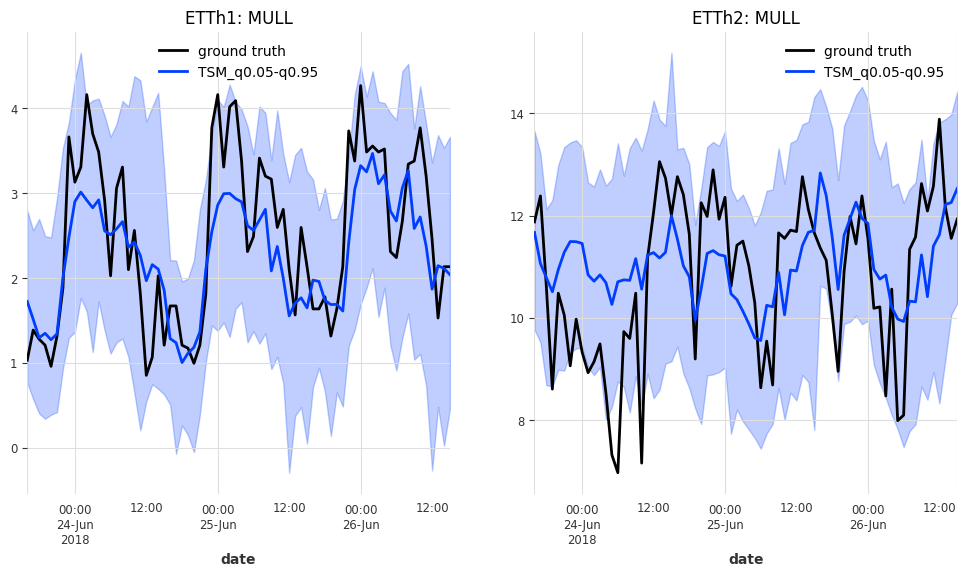

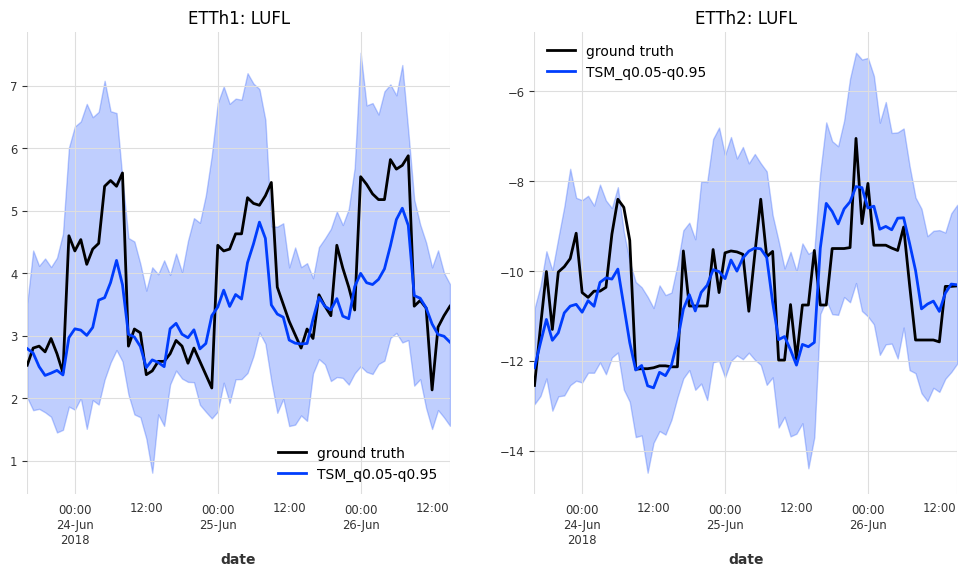

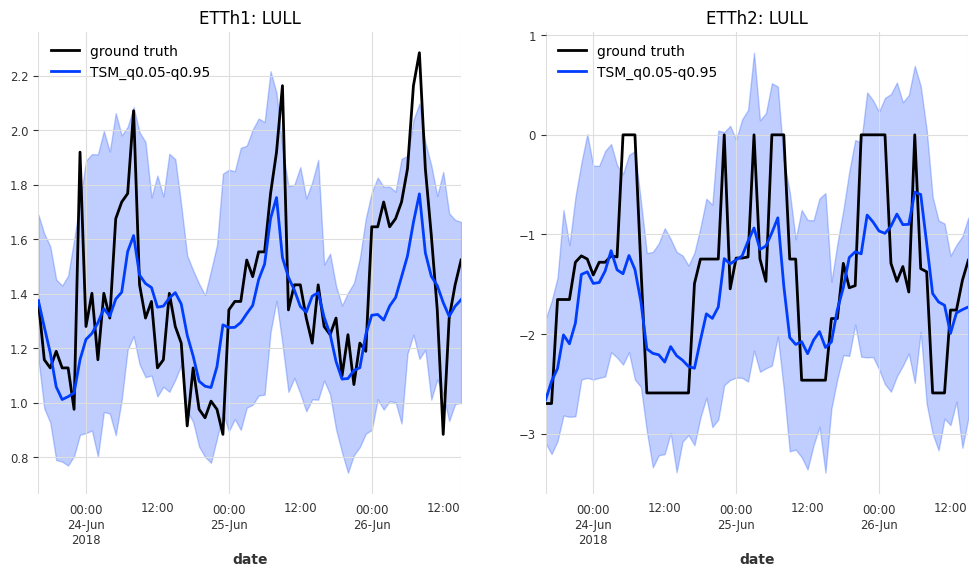

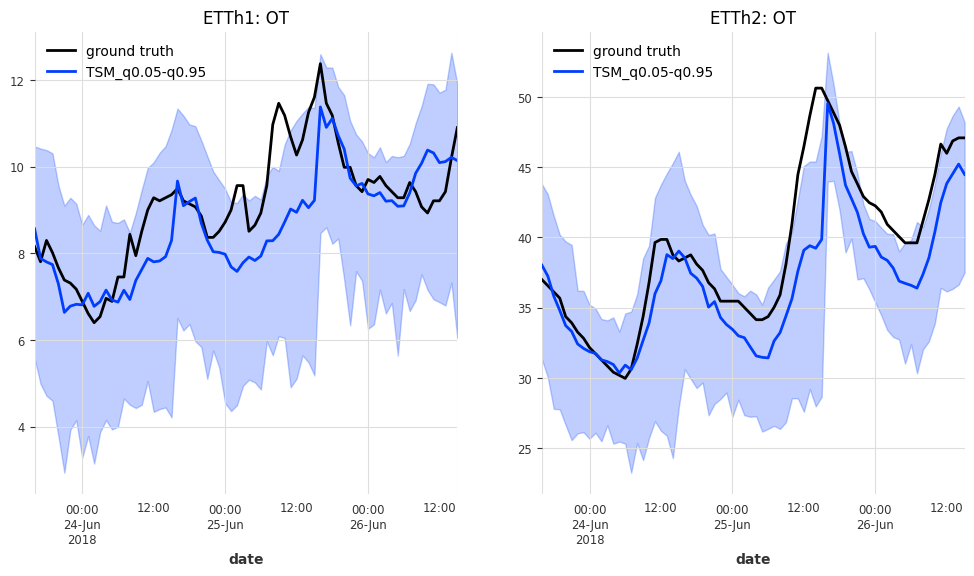

In [52]:
generate_plots(n_days=3, hfcs=hfcs)

# Results
In this case, `TSMixer` and `TiDEModel` both perform similarly well. Keep in mind that we performed only partial training on the data, and that we used the default model parameters without any hyperparameter tuning. 

Here are some ways to further improve the performance:

- set `full_training=True`
- perform hyperparameter tuning
- add more covariates (we have only added cyclic encodings of calendar information)
- ...